<div style="float:left">
    <h1 style="width:450px">Practical 9: Dimensions in Data</h1>
    <h2 style="width:450px">Transformation &amp; Dimensionality Reduction</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this session the focus is on MSOA-level Census data from 2011. Although it's not ideal to link 2011 data to 2020 data, we: a) have no other choice; and b) could actually do a bit of thinking about whether the situation in 2011 in some way helps us to predict the situation now...

## Preamble

Let's start with the usual bits of code to ensure plotting works, to import packages and load the data into memory.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn

In [2]:
from IPython.display import display_markdown

# This has been expanded to try to print out Pandas Series
# objects a little more intelligently as a Markdown table!
# We use f-strings everywhere because it ensures that we
# are working with string outputs.
def markdown_body(txt):
    if type(txt)==str:
        return "> " + txt
    elif type(txt)==pd.core.series.Series:
        out = '| Index | Value |\n| :----- | -----: |\n'
        for i in range(0,txt.shape[0]):
            out += f"| {txt.index[i]} | "
            if type(txt.iloc[i])==float or type(txt.iloc[i])==int or type(txt.iloc[i])==np.float64:
                out += f"{txt.iloc[i]:0.2f}"
            else:
                out += f"{txt.iloc[i]}"
            out += ' |\n'
        return out
    else:
        print(type(txt))
        return "> " + txt

# Notice how this has changed slightly to 
# call a function in the f-string instead
# of simply outputting the value. So we have
# a function calling a function!
def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n{markdown_body(body)}\n", raw=True)
    else:
        display_markdown(f"{markdown_body(body)}\n", raw=True)

## 1. Loading MSOA Census Data

Now we're going to add in _one_ more data set: London's MSOA 'Atlas' from the [London Data Store](https://data.london.gov.uk/dataset)! I would _strongly_ suggest that you have a look around the Data Store as you develop your thinking for the final assessment -- you will likely find useful additional data there!

Once you see how we deal with this MSOA Atlas data you will be in a position to look at the socio-economic **context** of Airbnb listings at the MSOA level, or with any other similar data set. If you're feeling particularly ambitious you can actually do this _same_ work at the LSOA scale using the [LSOA Atlas](https://data.london.gov.uk/dataset/lsoa-atlas) and LSOA boundaries... the process should be the same, though you will have smaller samples in each LSOA than you do in the MSOAs and calculations will take a bit longer to complete.

There is a CSV file for the MSOA Atlast that would be easier to work with; however, the Excel file is useful for demonstrating how to work with multi-level indexes (an extension of last week's work). Notice that below we do two new things when reading the XLS file:

1. We have to specify a sheet name because the file contains multiple sheets.
2. We have to specify a header _and_ we actually have to specify three of them which generates a multi-level index (row 0 is the top-level, row 1 is the second-level, etc.).

You might like to load a copy of the Excel file into Excel so that you can see how the next bit works. You can find the MSOA Atlas [here](https://data.london.gov.uk/dataset/msoa-atlas).

In [3]:
msoa_atlas = pd.read_excel(
    'https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls', 
    sheet_name='iadatasheet1', # Which sheet is the data in?
    header=[0,1,2])            # Where are the column names... there's three of them!

Notice the format of the output and notice that all of the empty cells in the Excel sheet have come through as `Unnamed: <col_no>_level_<level_no>`:

In [4]:
msoa_atlas.head(3)

Unnamed: 0_level_0        Unnamed: 1_level_0 Age Structure (2011 Census)  \
  Unnamed: 0_level_1        Unnamed: 1_level_1                    All Ages   
           MSOA Code                 MSOA Name          Unnamed: 2_level_2   
0          E02000001        City of London 001                      7375.0   
1          E02000002  Barking and Dagenham 001                      6775.0   
2          E02000003  Barking and Dagenham 002                     10045.0   

                                                                               \
                0-15              16-29              30-44              45-64   
  Unnamed: 3_level_2 Unnamed: 4_level_2 Unnamed: 5_level_2 Unnamed: 6_level_2   
0              620.0             1665.0             2045.0             2010.0   
1             1751.0             1277.0             1388.0             1258.0   
2             2247.0             1959.0             2300.0             2259.0   

                                        Mid-year Estimate totals  ...  \
                 65+        Working-age                 All Ages  ...   
  Unnamed: 7_level_2 Unnamed: 8_level_2                     2002  ...   
0             1035.0             5720.0                   7280.0  ...   
1             1101.0             3923.0                   6333.0  ...   
2             1280.0             6518.0                   9236.0  ...   

  Road Casualties                                                           \
             2010             2011                            2012           
           Slight 2010 Total Fatal Serious Slight 2011 Total Fatal Serious   
0           334.0      374.0   0.0    46.0  359.0      405.0   2.0    51.0   
1            18.0       18.0   0.0     2.0   16.0       18.0   0.0     1.0   
2            34.0       37.0   1.0     4.0   40.0       45.0   0.0     3.0   

                     
                     
  Slight 2012 Total  
0  361.0      414.0  
1   15.0       16.0  
2   47.0       50.0  

[3 rows x 207 columns]

In [5]:
print(f"Shape of the MSOA Atlas data frame is: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is: 984 x 207


You should get: `Shape of the MSOA Atlas data frame is: 984 x 207`.

And this should look a _bit_ familiar from last week's work with _grouped data frames_!

In [6]:
print(msoa_atlas.columns.get_level_values(0))

Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Mid-year Estimate totals',
       ...
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties'],
      dtype='object', length=207)


The _new_ thing to note here is that if we drop a level 0 index all then of the columns that it supports (levels 1 and 2) are _also_ dropped: so when we drop `Mid-year Estimate totals` from level 0 then all 11 of the 'Mid-year Estimate totals (2002...2012)' columns are dropped in one go.

In [7]:
msoa_atlas[['Mid-year Estimate totals']].head(3)

Mid-year Estimate totals                                                  \
                  All Ages                                                   
                      2002    2003    2004    2005    2006    2007    2008   
0                   7280.0  7115.0  7118.0  7131.0  7254.0  7607.0  7429.0   
1                   6333.0  6312.0  6329.0  6341.0  6330.0  6323.0  6369.0   
2                   9236.0  9252.0  9155.0  9072.0  9144.0  9227.0  9564.0   

                                      
                                      
     2009     2010     2011     2012  
0  7472.0   7338.0   7412.0   7604.0  
1  6570.0   6636.0   6783.0   6853.0  
2  9914.0  10042.0  10088.0  10218.0

In [8]:
to_drop = ['Mid-year Estimate totals','Mid-year Estimates 2012, by age','Religion (2011)',
           'Land Area','Lone Parents (2011 Census)','Central Heating (2011 Census)','Health (2011 Census)',
           'Low Birth Weight Births (2007-2011)','Obesity','Incidence of Cancer','Life Expectancy',
           'Road Casualties']
msoa_atlas.drop(to_drop, axis=1, level=0, inplace=True)
print(f"Shape of the MSOA Atlas data frame is now: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 111


This should drop you down to `984 x 111`. Notice below that the multi-level _index_ has not changed but the multi-level _values_ remaining have!

In [9]:
print(msoa_atlas.columns.levels[0]) # The categories
print(msoa_atlas.columns.get_level_values(0)) # The actual values

Index(['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 'Economic Activity (2011 Census)',
       'Ethnic Group (2011 Census)', 'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 'Household Income Estimates (2011/12)',
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)',
       'Unnamed: 0_level_0', 'Unnamed: 1_level_0'],
      dtype='object')
Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census

#### Task 1.1: Selecting Columns using a List Comprehension

Now we need to drop all of the percentages from the data set. These can be found at level 1, though they are specified in a number of different ways so you'll need to come up with a way to find them in the level 1 values using a list comprehension... 

I'd suggest looking for: "(%)", "%", and "Percentages". You may need to check both start and end.

In [10]:
to_drop = [x for x in msoa_atlas.columns.get_level_values(1) if (
    x.endswith("(%)") or 
    x.startswith("%") or 
    x.endswith("Percentages") or 
    x.endswith("%"))]
print(to_drop)

['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income depri

You should get:
```
['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income deprived households reliant on means tested benefit', '% of people aged over 60 who live in pension credit households', 'No cars or vans in household (%)', '1 car or van in household (%)', '2 cars or vans in household (%)', '3 cars or vans in household (%)', '4 or more cars or vans in household (%)']
```

#### Task 1.2: Drop by Level

You now need to drop these columns using the `level` keyword as part of your drop command. You have plenty of examples of how to drop values in place, but I'd suggest _first_ getting the command correct and allowing to it return a new data frame and _then_ adding the in place parameter.

In [11]:
msoa_atlas.drop(to_drop, level = 1, axis=1, inplace = True)
print(f"Shape of the MSOA Atlas data frame is now: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 76


The data frame is now `984 x 76`. This is a _bit_ more manageable though still a _lot_ of data columns. Depending on what you decide to do for your final project you might want to revisit some of the columns that we dropped above... 

#### Task 1.3: Flattening the Index

Level 2 of the multi-index is mainly composed of 'Unnamed' values so we want to merge it with Level 1 to simplify our data frame, and then merge _that_ with level 0... Unlike a 'regular' data frame, asking for the column values on a data frame with a hierarhical index will give you an array of tuples: with one element for each level of the index for _each_) column!

In [12]:
# Notice how each column 'name' is actually a tuple!
msoa_atlas.columns.values[:3]

array([('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
       ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'MSOA Name'),
       ('Age Structure (2011 Census)', 'All Ages', 'Unnamed: 2_level_2')],
      dtype=object)

In [13]:
msoa_atlas.columns.values

array([('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
       ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'MSOA Name'),
       ('Age Structure (2011 Census)', 'All Ages', 'Unnamed: 2_level_2'),
       ('Age Structure (2011 Census)', '0-15', 'Unnamed: 3_level_2'),
       ('Age Structure (2011 Census)', '16-29', 'Unnamed: 4_level_2'),
       ('Age Structure (2011 Census)', '30-44', 'Unnamed: 5_level_2'),
       ('Age Structure (2011 Census)', '45-64', 'Unnamed: 6_level_2'),
       ('Age Structure (2011 Census)', '65+', 'Unnamed: 7_level_2'),
       ('Age Structure (2011 Census)', 'Working-age', 'Unnamed: 8_level_2'),
       ('Households (2011)', 'All Households', 'Unnamed: 42_level_2'),
       ('Household Composition (2011)', 'Numbers', 'Couple household with dependent children'),
       ('Household Composition (2011)', 'Numbers', 'Couple household without dependent children'),
       ('Household Composition (2011)', 'Numbers', 'Lone parent household'),
       ('Household Com

In [14]:
new_cols = []
for c in msoa_atlas.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}" # level 1
    l2 = f"{c[1]}" # level 2
    l3 = f"{c[2]}" # level 3

    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        l2 = l2.replace('At least one person aged 16 and over in household has English as a main language',"1+ English as a main language").replace("No people in household have English as a main language","None have English as main language")
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    
    new_cols.append(clabel)

print(new_cols)

['MSOA Code', 'MSOA Name', 'Age - All Ages', 'Age - 0-15', 'Age - 16-29', 'Age - 30-44', 'Age - 45-64', 'Age - 65+', 'Age - Working-age', 'Households - All Households', 'Composition - Couple hh with dependent children', 'Composition - Couple hh without dependent children', 'Composition - Lone parent hh', 'Composition - One person hh', 'Composition - Other hh Types', 'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 'Black/African/Caribbean/Black British', 'Other ethnic group', 'BAME', 'Country of Birth - United Kingdom', 'Country of Birth - Not United Kingdom', 'Language - 1+ English as a main language', 'Language - None have English as main language', 'Tenure - Owned outright', 'Tenure - Owned with a mortgage or loan', 'Tenure - Social rented', 'Tenure - Private rented', 'Household spaces with at least one usual resident', 'Household spaces with no usual residents', 'Detached', 'Semi-detached', 'Terraced (including end-terrace)', 'Flat, maisonette or apartment', 'Populat

In [15]:
# Assign these back to the original data frame
# to replace the multi-level index
msoa_atlas.columns = new_cols
msoa_atlas.head()

,MSOA Code,MSOA Name,Age - All Ages,Age - 0-15,Age - 16-29,Age - 30-44,Age - 45-64,Age - 65+,Age - Working-age,Households - All Households,...,Adults in Employment - No adults in employment in hh: With dependent children,Total Mean hh Income,Total Median hh Income,Vehicles - No cars or vans in hh,Vehicles - 1 car or van in hh,Vehicles - 2 cars or vans in hh,Vehicles - 3 cars or vans in hh,Vehicles - 4 or more cars or vans in hh,Vehicles - Sum of all cars or vans in the area,Vehicles - Cars per hh
0,E02000001,City of London 001,7375.0,620.0,1665.0,2045.0,2010.0,1035.0,5720.0,4385.0,...,38.0,59728.481886,46788.295472,3043.0,1100.0,173.0,51.0,18.0,1692.0,0.385861
1,E02000002,Barking and Dagenham 001,6775.0,1751.0,1277.0,1388.0,1258.0,1101.0,3923.0,2713.0,...,319.0,31788.185996,27058.703760,1020.0,1186.0,424.0,66.0,17.0,2305.0,0.849613
2,E02000003,Barking and Dagenham 002,10045.0,2247.0,1959.0,2300.0,2259.0,1280.0,6518.0,3834.0,...,268.0,43356.931547,36834.528738,1196.0,1753.0,691.0,155.0,39.0,3766.0,0.982264
3,E02000004,Barking and Dagenham 003,6182.0,1196.0,1277.0,1154.0,1543.0,1012.0,3974.0,2318.0,...,122.0,46701.436554,39668.206433,556.0,1085.0,515.0,128.0,34.0,2650.0,1.143227
4,E02000005,Barking and Dagenham 004,8562.0,2200.0,1592.0,1995.0,1829.0,946.0,5416.0,3183.0,...,307.0,34293.820288,29155.683536,1080.0,1423.0,551.0,109.0,20.0,2937.0,0.922714


#### Task 1.4: Add Inner/Outer London Mapping

Using the mapping that you created last week, now try to applying it as a **lambda** function to populate a new column called `Subregion` using the `Borough` column as a source. The format for a lambda function is usually `lambda x: <code that does something with x and returns a value>`. Hint: you've got a dictionary and you know how to use it!

In [16]:
msoa_atlas['Borough'] = msoa_atlas['MSOA Name'].str.replace(' \d+$','')


/tmp/ipykernel_2618/3736668192.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  msoa_atlas['Borough'] = msoa_atlas['MSOA Name'].str.replace(' \d+$','')


In [17]:
# You might want to have a look at _what_ this drops first
msoa_atlas.drop(index=msoa_atlas[msoa_atlas['MSOA Code'].isna()].index, inplace=True)


In [21]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

msoa_atlas['Subregion'] = msoa_atlas.Borough.apply(lambda x: mapping[x])


In [22]:
msoa_atlas.Borough

0            City of London
1      Barking and Dagenham
2      Barking and Dagenham
3      Barking and Dagenham
4      Barking and Dagenham
               ...         
978             Westminster
979             Westminster
980             Westminster
981             Westminster
982             Westminster
Name: Borough, Length: 983, dtype: object

#### And Save

In [23]:
msoa_atlas.to_csv(os.path.join('data','clean','MSOA_Atlas.csv.gz'), index=False)
print("Done.")

Done.


#### Task 1.5: Merge with MSOA Data

In [24]:
msoas = gpd.read_file(os.path.join('data','geo','London_MSOAs.gpkg'), driver='GPKG')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [26]:
gdf = pd.merge(msoas, msoa_atlas, how = 'inner', 
               left_on = "MSOA11CD", right_on = "MSOA Code")

gdf = gdf.drop(columns=['MSOA11CD','MSOA11NM', 'Borough_x']).rename(columns={'Borough_y':'Borough'})

print(f"Final MSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final MSOA Atlas data frame has shape 983 x 83


You should get `Final data frame has shape 983 x 83`.

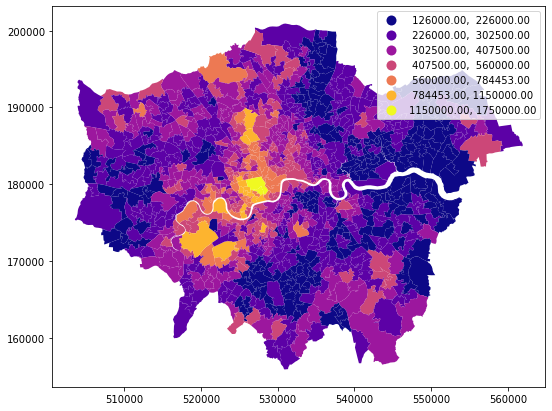

In [27]:
gdf.plot(column='Median - 2011', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

#### Save as GeoPackage

In [28]:
gdf.to_file(os.path.join('data','geo','MSOA_Atlas.gpkg'), driver='GPKG')
print("Done.")

Done.


## 2. Splitting a Data Set into Test & Train

A standard approach to Machine Learning, and something that is becoming more widely used elsewhere, is the splitting of a large data into set into testing and training components. Typically, you would take 80-90% of your data to 'train' your algorithm and withold between 10-20% for validation ('testing'). An even 'stricter' approach, in the sense of trying to ensure the robustness of your model against outlier effects, is [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) such as [k-folds cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). Here we are just going to use it to explore the issues raised in normalisation and standardisation by the use of SciKit-Learn's pipeline architecture with streaming data.

So Sci-Kit Learn is often used in a model-validation context in which we are trying to _predict_ something. So Sci-Kit Learn _expects_ that you'll have an `X` which is your **predictors** (the inputs to your model) and a `y` which is the thing you're **trying to predict**. We're obviously not building a model here (that's for Term 2!) so we'll just 'pretend' that we're trying to predict the price of a listing and will set that up as our `y` data set. Notice too that you can pass a data frame directly to Sci-Kit Learn and it will split it for you.

#### Reload

On subsequent runs of this notebook you might just want to start here!

In [29]:
gdf = gpd.read_file(os.path.join('data','geo','MSOA_Atlas.gpkg'), driver='GPKG')
print(gdf.shape)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(983, 83)


In [30]:
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

For our purposes this is a little bit overkill as you could also use pandas' `sample(frac=0.2)` and the indexes, but it's useful to see how this works. Ordinarily, you would use this when building a model where you have both predictors _and_ a target. These would be held separately and then you use test/train split to ensure that you get four data sets out the training (predictors + target as separate data sets) and the training (predictors + target as separate data sets) accoridng to the `test_size` specfied in the `test_train_split` parameters.

In [31]:
from sklearn.model_selection import train_test_split 

pdf = gdf['Median - 2011'].copy() # pdf for Median *P*rice b/c we need *something*

#x train, x test, y train, y test
df_train, df_test, pr_train, pr_test = train_test_split(gdf, pdf, test_size=0.2, random_state=44)

Below you should see that the data has been split roughly on the basis of the `test_size` parameter.

In [32]:
print(f"Original data size: {gdf.shape[0]:,} x {gdf.shape[1]}")
print(f"Training data size: {df_train.shape[0]:,} x {df_train.shape[1]}")
print(f"Testing data size:    {df_test.shape[0]:,} x {df_test.shape[1]}")

Original data size: 983 x 83
Training data size: 786 x 83
Testing data size:    197 x 83


Also notice the indexes of the testing data sets:

In [34]:
print(", ".join([str(x) for x in df_train.index[:10]]))
print(", ".join([str(x) for x in pr_train.index[:10]]))

810, 502, 471, 74, 415, 316, 15, 37, 877, 449
810, 502, 471, 74, 415, 316, 15, 37, 877, 449


#### Task 2.1: Plotting the Test/Train Data Sets

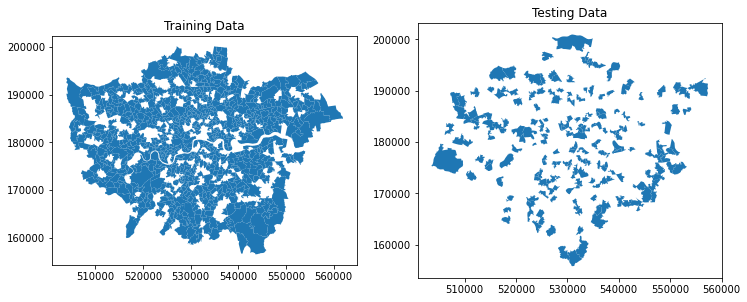

In [38]:
f,axes = plt.subplots(1,2, figsize=(12,5))
df_train.plot(ax=axes[0]) #training
df_test.plot(ax=axes[1]) #testing
axes[0].set_title('Training Data')
axes[1].set_title('Testing Data');

## 3. Normalisation

The developers of [SciKit-Learn](https://scikit-learn.org/) define [normalisation](https://scikit-learn.org/stable/modules/preprocessing.html#normalization) as "scaling individual samples to have **unit norm**." There are a _lot_ of subtleties to this when you start dealing with 'sparse' data, but for the most part it's worthwhile to think of this as a rescaling of the raw data to have similar ranges in order achieve some kind of comparison. This is such a common problem that sklearn offers a range of such (re)scalers including: `MinMaxScaler`.

Let's see what effect this has on the data!

In [39]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")
# Set the *hue order* so that all plots have some colouring by Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

#### Task 3.1: Range Normalisation

There is some 'dense' code in here, make sure you that you understand what is happening in the loops and the dataframe copies! 

In [40]:
# You could change these...
cols = ['Tenure - Owned outright', 'Tenure - Owned with a mortgage or loan',
        'Tenure - Social rented', 'Tenure - Private rented']

In [42]:
df_train[cols].describe()

,Tenure - Owned outright,Tenure - Owned with a mortgage or loan,Tenure - Social rented,Tenure - Private rented
count,786.000000,786.000000,786.000000,786.000000
mean,697.704835,894.790076,794.304071,834.450382
std,341.807935,338.532051,580.297861,453.531831
min,77.000000,174.000000,17.000000,93.000000
25%,446.750000,628.500000,336.000000,503.500000
50%,658.000000,890.500000,661.000000,775.500000
75%,906.250000,1125.750000,1140.250000,1094.750000
max,2127.000000,2089.000000,3145.000000,2717.000000


What is being fitted here???

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Notice what this is doing! See if you can explain it clearly.
scalers = [MinMaxScaler().fit(df_train[x].values.reshape(-1,1)) for x in cols]

In [45]:
tr_normed = df_train[cols+['Subregion']].copy()

for i in range(0, len(cols)):
    # Ditto this -- can you explain what this code is doing
    tr_normed[cols[i]] = scalers[i].transform(df_train[cols[i]].values.reshape(-1,1))

In [46]:
tst_normed = df_test[cols+['Subregion']].copy()

for i in range(0, len(cols)):
    # What is this doing differently?
    tst_normed[cols[i]] = scalers[i].transform(df_test[cols[i]].values.reshape(-1,1))

In [47]:
tr_normed.columns  = [re.sub('( - |/)',"\n",x) for x in tr_normed.columns.values]
tst_normed.columns = [re.sub('( - |/)',"\n",x) for x in tst_normed.columns.values]

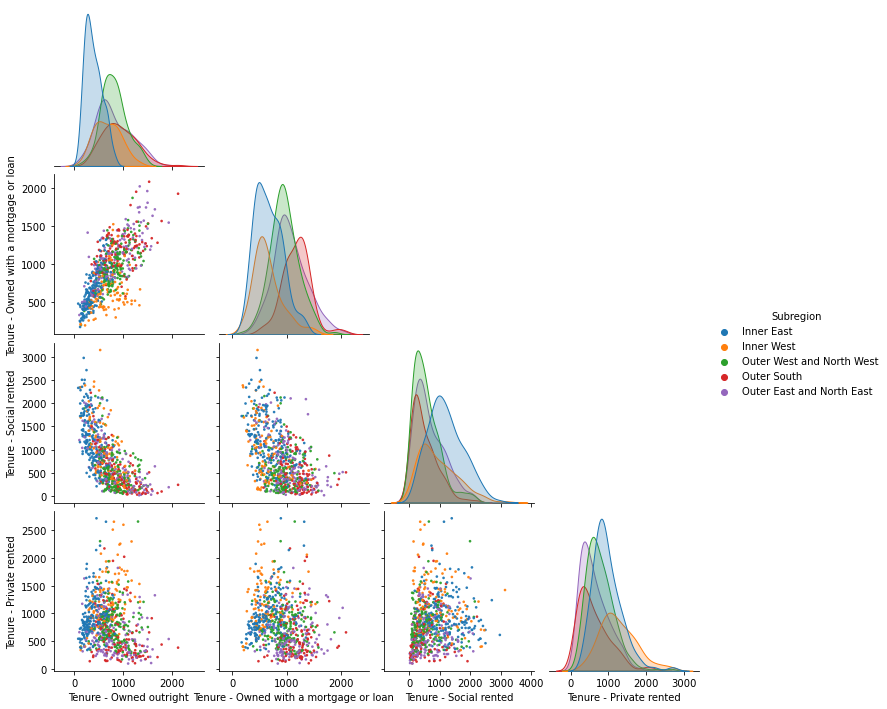

In [48]:
sns.pairplot(data=df_train[cols+['Subregion']], hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

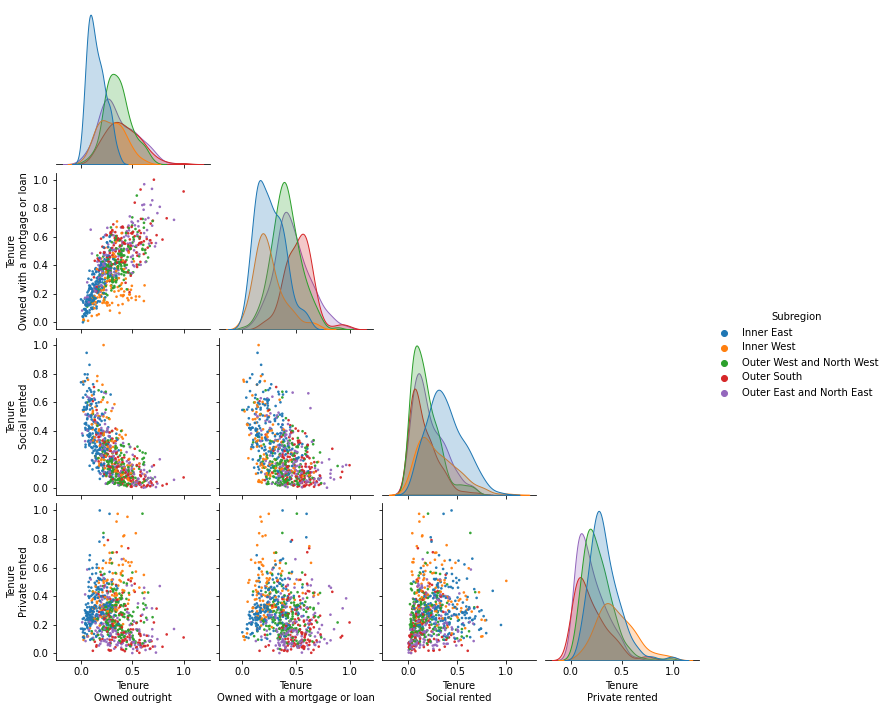

In [49]:
sns.pairplot(data=tr_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

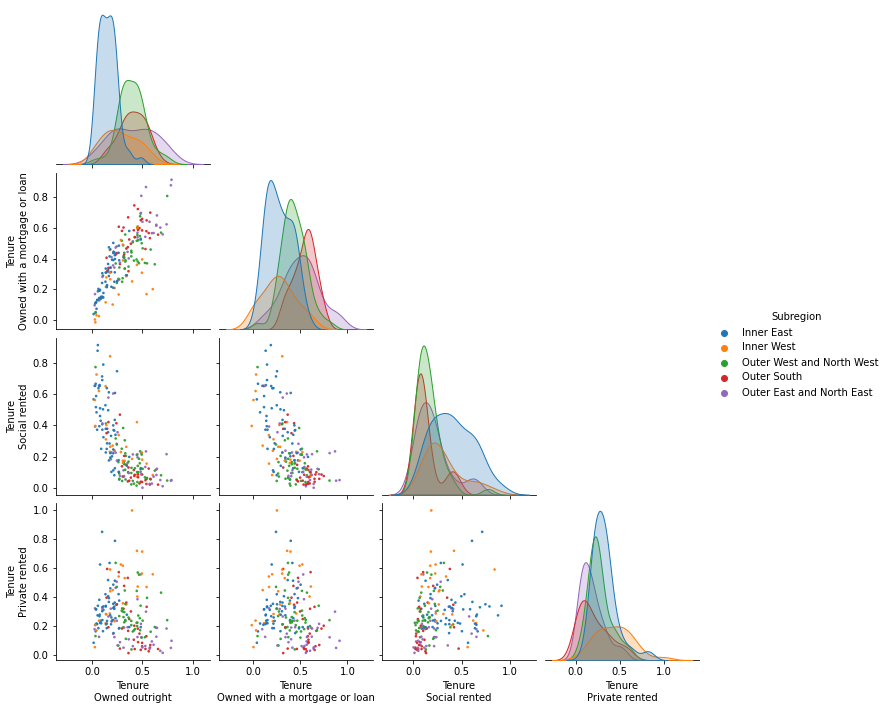

In [50]:
sns.pairplot(data=tst_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

#### Task 3.2: Why???

Why do I keep writing `df[cols+['Subregion']`? Why I don't just add it to the `cols` variable at the start?

> Your answer here!

#### Task 3.3: Change, change, changes!

What do you notice about the `df_train` (raw training data) and `tr_normed` (normalised training data) data sets? What do you notice about the `tst_normed` results? What is the _potential_ problem that different 'realisations' of `tst_normed` might cause.

> Your answer here!

## 4. Standardisation 

Recall that standardisation is typically focussed on rescaling data to have a mean (or median) of 0 and standard deviation or IQR of 1 and that these approaches are therefore closely tied to the idea of the standard normal distribution. However, and rather confusingly, many data scientists will refer to standardisation and normalisation largely interchangeably.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [52]:
# You could do this for any column
col = 'Vehicles - No cars or vans in hh'
tr  = df_train[[col]].copy()
tst = df_test[[col]].copy()

#### Task 4.1: Z-Score Standardisation

In [53]:
ss = StandardScaler()

ss.fit(tr[col].values.reshape(-1,1))

tr[f"Z. {col}"]  = ss.transform(tr[col].values.reshape(-1,1))
tst[f"Z. {col}"] = ss.transform(tst[col].values.reshape(-1,1))

#### Task 4.2: Inter-Quartile Standardisation

In [54]:
rs = RobustScaler(quantile_range=(25.0, 75.0))

rs.fit(tr[col].values.reshape(-1,1))

tr[f"IQR. {col}"] = rs.transform(tr[col].values.reshape(-1,1))
tst[f"IQR. {col}"] = rs.transform(tst[col].values.reshape(-1,1))

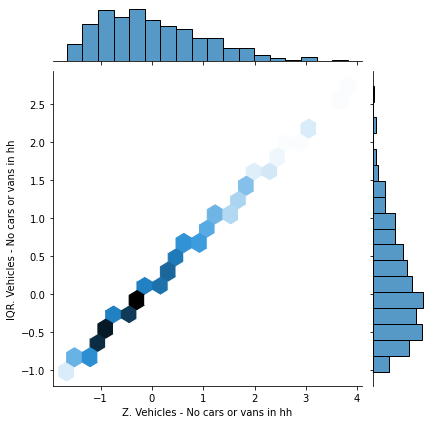

In [56]:
sns.jointplot(data=tr, 
              x=f"Z. {col}", 
              y=f"IQR. {col}", 
              kind='hex'); # hex probably not the best choice

Perhaps a little more useful...

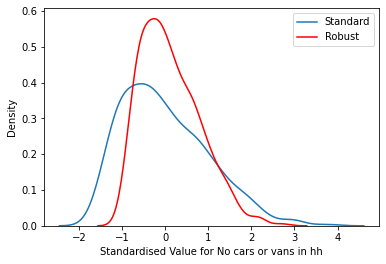

In [57]:
ax = sns.kdeplot(tr[f"Z. {col}"])
sns.kdeplot(tr[f"IQR. {col}"], color='r', ax=ax)

# Notice some of the customisations that we add here...
# May be try experimenting with them yourself?
plt.legend(loc='upper right', labels=['Standard', 'Robust'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Standardised Value for No cars or vans in hh");

#### Task 4.3: Differences?

Can you see the differences between these two rescalers, and can you explain why you might want to choose one over the other?

> IQR: uses median, Z-score: uses mean
> This case, skewed -> IQR

----

## 5. Non-Linear Transformations

So transformations are useful when a data series has features that make comparisons or analysis difficult, or that affect our ability to intuit meaningful difference. By manipulating the data using one or more mathematical operations we can sometimes make it more *tractable* for subsequent analysis. In other words, it's all about the _context_ of our data.

[![How tall is tall?](http://img.youtube.com/vi/-VjcCr4uM6w/0.jpg)](http://www.youtube.com/watch?v=-VjcCr4uM6w)

From above, we know the _MedianIncome_ data are _not_ normally distributed, but can we work out what distribution best represents _MedianIncome_? This can be done by comparing the shape of the histogram to the shapes of theoretical distributitions. For example:

- the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution
- the [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) distribution
- the [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution (for non-continuous data)
 
From looking at those theoretical distributions, we might make an initial guess as to the type of distribution. There are actually _many_ other distributions encountered in real life data, but these ones are particuarly common. A wider view of this would be that [quantile and power transformations](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation) are ways of preserving the rank of values but lose many of the other features of the relationships that might be preserved by, for instance, the standard scaler.

In the case of Median Income, taking a log-transform of the data might make it _appear_ more normal: you do **not** say that a transformation _makes_ data more normal, you say either that 'it allows us to treat the data as normally distributed' or that 'the transformed data follows a log-normal distribution'.

#### Task 5.1: The Normal Distribution

Z-scores are often associated with the normal distribution because their interpretation implicitly assumes a normal distribution. Or to put it another way... You can always calculate z-scores for your data (it's just a formula applied to data points), but their _intuitive meaning_ is lost if your data don't have something like a normal distribution (or follow the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68–95–99.7_rule)).

But... what if our data are non-normal? Well, Just because data are non-normal doesn't mean z-scores can't be calculated; we just have to be careful what we do with them... and sometimes we should just avoid them entirely. 

Below is a function to create that theoretical normal distribution. See if you can understand what's going and add comments to the code to explain what each line does. You may need to look up what `np.random.normal` does...

In [58]:
def normal_from_dist(series):  #define function name and required arguments (in this case a pandas series)
    mu = series.mean()         #calculate the mean of our data
    sd = series.std()          #calculate the standard deviation of our data
    n  = len(series)           #count how many observations are in our data
    s = np.random.normal(mu, sd, n)   #use the parameters of the data just calculated to generate n random numbers, drawn from a normal distributions 
    return s                   #return this set of random numbers

To make it easier to understand what the function above is doing, let's use it! We'll use the function to plot both a distribution plot with both histogram and KDE for our data, and then add a _second_ overplot distplot to the same fig showing the theoretical normal distribution (in red). We'll do this in a loop for each of the three variables we want to examine.

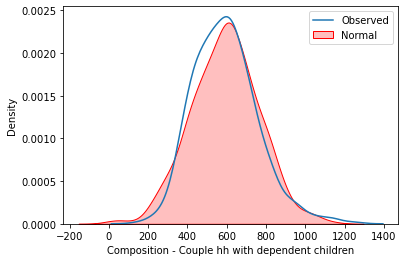

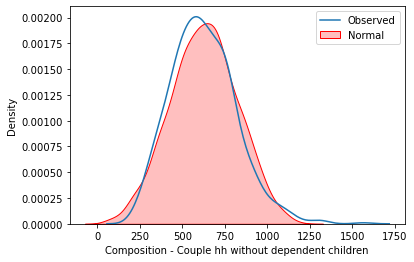

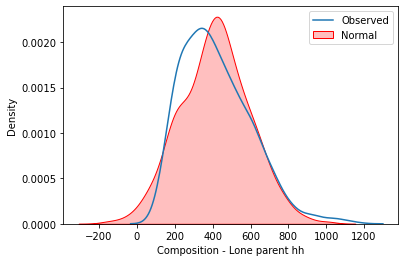

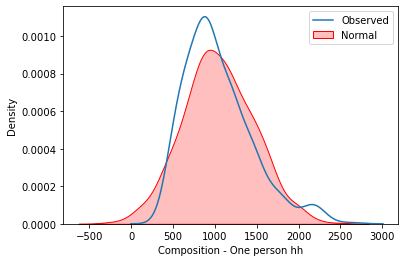

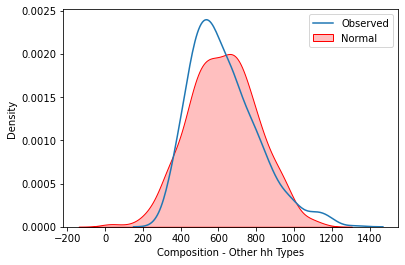

In [59]:
selection = [x for x in df_train.columns.values if x.startswith('Composition')]

for c in selection:
    ax = sns.kdeplot(df_train[c])
    sns.kdeplot(normal_from_dist(df_train[c]), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title='Foo'
    ax.ticklabel_format(useOffset=False, style='plain')
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.show()

#### Task 5.2: Am I Normal?

Which, if any, of the variables has a roughly normal distribution? Another way to think about this question is, for which of the variables are the mean and standard deviation _most_ appropriate as measures of centrality and spread?

> KS test - tests which distribution it matches the most well with

#### Task 5.3: Meaningful? 

How might you determine the _significance_ of some of the departures from the normal distribution?

> Your answer here.

#### Task 5.4: Logarithmic Transformations

To create a new series in the data frame containing the natural log of the original value it’s a similar process to what we've done before, but since pandas doesn't provide a log-transform operator (i.e. you can’t call `df['MedianIncome'].log()` ) we need to use the `numpy` package since pandas data series are just numpy arrays with some fancy window dressing that makes them even _more_ useful:
```python
series = pd.Series(np.log(df.<series>))
```
Let's perform the transform then compare to the un-transformed data. Comment the code below to ensure that you understand what it is doing. 

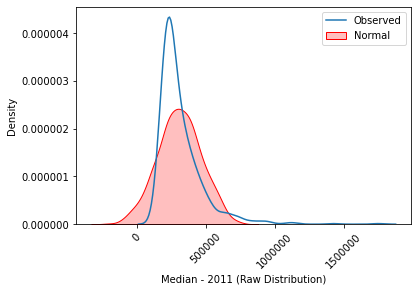

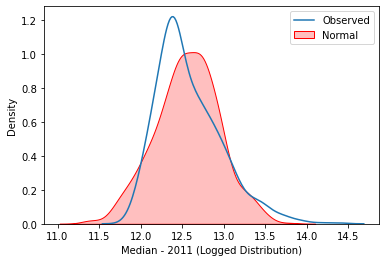

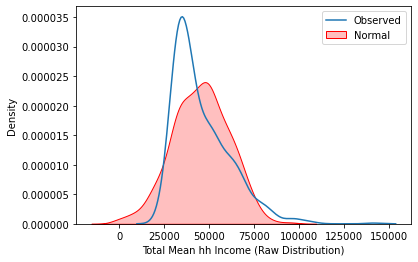

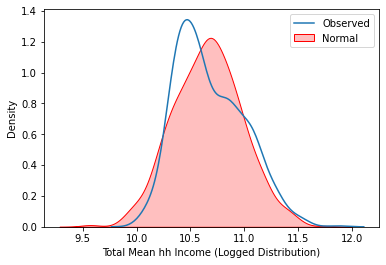

In [60]:
cols = ['Median - 2011','Total Mean hh Income']

for m in cols:
    s  = df_train[m] # s == series
    ts = np.log(s)   # ts == transformed series
    
    ax = sns.kdeplot(s)
    sns.kdeplot(normal_from_dist(s), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title also an option
    
    ### USEFUL FORMATTING TRICKS ###
    # This turns off scientific notation in the ticklabels
    ax.ticklabel_format(useOffset=False, style='plain')
    # Notice this snippet of code
    ax.set_xlabel(ax.get_xlabel() + " (Raw Distribution)")
    # Notice this little code snippet too
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    
    plt.show()
    
    ax = sns.kdeplot(ts)
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(ax.get_xlabel() + " (Logged Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.show()

Hopefully, you can see that the transformed data do indeed look 'more normal'; the peak of the red and blue lines are closer together and the blue line at the lower extreme is also closer to the red line, but we can check this by seeing what has happened to the z-scores.

## 6. Principal Components Analysis

Now we're going to ask the question: how can we represent our data using a smaller number of components that capture the variance in the original data.

#### Optional Reload

Use this is your data gets messy...

In [61]:
gdf = gpd.read_file(os.path.join('data','geo','MSOA_Atlas.gpkg'), driver='GPKG')
print(gdf.shape)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(983, 83)


In [62]:
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

#### Task 6.1: Removing Non-Numeric Data

To perform PCA we can only have numeric data. In theory, categorical data can be converted to numeric and retained, but there are two issues:

1. Nominal data has no _innate_ order so we _can't_ convert > 2 categories to numbers and have to convert them to One-Hot Encoded values.
2. A binary (i.e. One-Hot Encoded) variable will account for a _lot_ of variance in the data because it's only two values are 0 and 1!

So in practice, it's probably a good idea to drop categorical data if you're planning to use PCA.

In [63]:
to_drop = ['OBJECTID', 'BNG_E', 'BNG_N', 'msoa11hclnm', 
           'MSOA Name', 'Borough', 'Subregion', 'geometry']
gdf_pca = gdf.drop(columns=to_drop).set_index('MSOA Code').copy()

#### Task 6.2: Rescaling

In order to ensure that our results aren't dominated by a single scale (e.g. House Prices!) we need to rescale all of our data. You could easily try different scalers as well as a different parameters to see what effect this has on your results.

In [64]:
rs = RobustScaler(quantile_range=(10.0, 90.0))

for c in gdf_pca.columns.values:
    gdf_pca[c] = rs.fit_transform(gdf_pca[c].values.reshape(-1, 1))

#### Task 6.3: Perform PCA on Rescaled Data

In [66]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=50, whiten=True)  #75 to 50 components

pca.fit(gdf_pca)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

#### Task 6.4: Examine Explained Variance

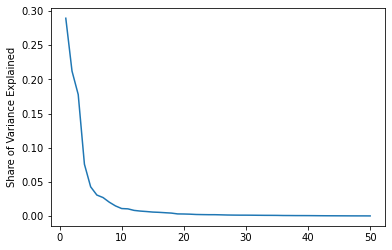

In [67]:
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [68]:
for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 28.95% of variance
Component  1 accounts for 21.23% of variance
Component  2 accounts for 17.79% of variance
Component  3 accounts for 7.59% of variance
Component  4 accounts for 4.29% of variance
Component  5 accounts for 3.09% of variance
Component  6 accounts for 2.72% of variance
Component  7 accounts for 2.04% of variance
Component  8 accounts for 1.50% of variance
Component  9 accounts for 1.11% of variance
Component 10 accounts for 1.06% of variance
Component 11 accounts for 0.84% of variance
Component 12 accounts for 0.74% of variance
Component 13 accounts for 0.67% of variance
Component 14 accounts for 0.59% of variance
Component 15 accounts for 0.56% of variance
Component 16 accounts for 0.50% of variance
Component 17 accounts for 0.45% of variance
Component 18 accounts for 0.33% of variance
Component 19 accounts for 0.31% of variance


#### Task 6.5: How Many Components?

There are a number of ways that we could set a threshold for dimensionality reduction: 
- The most common is to look for the 'knee' in the Explained Variance plot above. That would put us at about 5 retained components.
- Another is to just keep all components contributing more than 1% of the variance. That would put us at about 10 components.
- You can also ([I discovered](https://medium.com/@nikolay.oskolkov/hi-jon-reades-my-sincere-apologies-for-this-very-late-reply-444f57054d14)) look to shuffle the data and repeatedly perform PCA to build confidence intervals. I have not implemented this (yet).

In order to _do_ anything with these components we need to somehow re-attach them to the MSOAs. But first, the easiest thing to do is re-run PCA using the desired number of components. This also demonstrates its determinism.

In [69]:
keep_n_components = 10

# If we weren't changing the number of components we
# could re-use the pca object created above. 
pca = PCA(n_components=keep_n_components, whiten=True)

X_train = pca.fit_transform(gdf_pca)

# Notice that we get the _same_ values out,
# so this is a *deterministic* process that
# is fully replicable (allowing for algorithmic
# and programming language differences).
for i in range(0, keep_n_components):
    print(f"Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>2.2f}% of variance")

# Notice...
print(len(X_train))
print(gdf_pca.shape[0])
# So each observation has a row in X_train and there is 
# 1 column for each component. This defines the mapping
# of the original data space into the reduced one
print(len(X_train[0])) 

Component  0 accounts for 28.95% of variance
Component  1 accounts for 21.23% of variance
Component  2 accounts for 17.79% of variance
Component  3 accounts for 7.59% of variance
Component  4 accounts for 4.29% of variance
Component  5 accounts for 3.09% of variance
Component  6 accounts for 2.72% of variance
Component  7 accounts for 2.04% of variance
Component  8 accounts for 1.50% of variance
Component  9 accounts for 1.11% of variance
983
983
10


#### Task 6.6: Components to Columns

In [70]:
for x in [X_train]:
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])

    for i in range(0,keep_n_components):
        gdf_pca[f"Component {i+1}"] = new_columns[i]

In [71]:
gdf_pca.sample(3)

,Age - All Ages,Age - 0-15,Age - 16-29,Age - 30-44,Age - 45-64,Age - 65+,Age - Working-age,Households - All Households,Composition - Couple hh with dependent children,Composition - Couple hh without dependent children,...,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA Code,,,,,,,,,,,,,,,,,,,,,
E02000369,0.951195,0.470756,1.006904,0.982039,0.189206,-0.052656,1.084376,1.097930,-0.032274,0.221040,...,0.197110,2.303623,1.352589,0.003461,1.432314,-0.852855,-2.310172,-1.012119,-0.349697,1.588791
E02000651,0.120352,0.052603,0.097694,0.211472,0.100289,-0.038615,0.184793,0.162829,-0.002483,-0.034793,...,-0.104857,0.386370,0.197607,-0.403768,-0.117768,-0.014672,0.287979,-0.458317,0.050135,-1.974124
E02000085,-0.072764,-0.012482,-0.170640,-0.371524,0.265715,0.466885,-0.188679,-0.074436,0.377358,0.251740,...,-0.327801,-1.551573,0.937555,-0.574462,0.231011,0.887982,0.545730,1.745966,-0.727366,0.177544


#### Task 6.7: Attaching GeoData

In [72]:
msoas = gpd.read_file(os.path.join('data','geo','London_MSOAs.gpkg'), driver='GPKG')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Merge using the indexes...

In [74]:
pcadf = pd.merge(msoas.set_index('MSOA11CD'), gdf_pca, left_index=True, right_index=True, how='inner')
print(f"PCA df has shape {pcadf.shape[0]} x {pcadf.shape[1]}")
pcadf.sample(3)

PCA df has shape 983 x 91


,OBJECTID,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm,geometry,Age - All Ages,Age - 0-15,Age - 16-29,...,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000416,401,Haringey 020,530420,189352,Haringey,Hornsey East,"POLYGON ((530632.839 189823.067, 530738.773 18...",-0.184263,-0.199715,-0.134167,...,-0.106168,0.495069,-0.323206,-1.317452,0.395148,-0.392764,0.064407,-0.411802,-0.247133,-0.519443
E02000062,61,Barnet 039,523299,187266,Barnet,Brent Cross & Staples Corner,"POLYGON ((523254.128 188130.932, 523351.652 18...",-0.502435,-0.209522,-0.127654,...,-0.822103,-0.001280,-1.516831,-0.020655,-0.184660,-0.062805,0.528033,-0.189906,-0.578837,-0.315926
E02000077,75,Bexley 013,547045,176511,Bexley,St Michael's,"POLYGON ((547454.208 176918.500, 547453.337 17...",-0.092131,0.034772,-0.278103,...,-0.513008,-1.478438,0.429523,-0.150442,0.299789,0.827576,0.133447,1.368706,-2.132235,0.671026


You should get `Final data frame has shape 983 x 91`.

#### Task 6.8: Map the First _n_ Components

How would you automate this so that the loop creates one plot for each component?

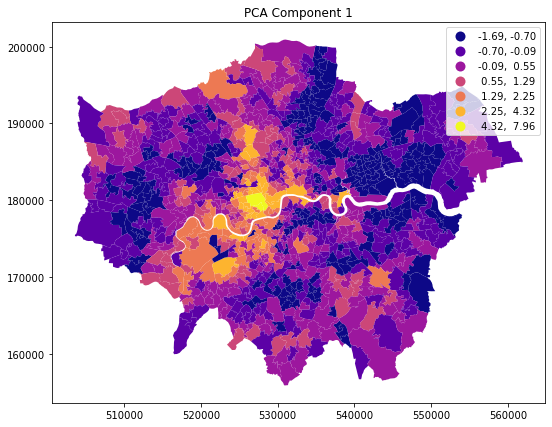

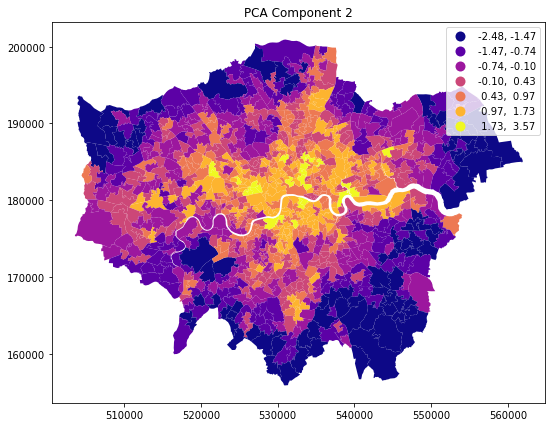

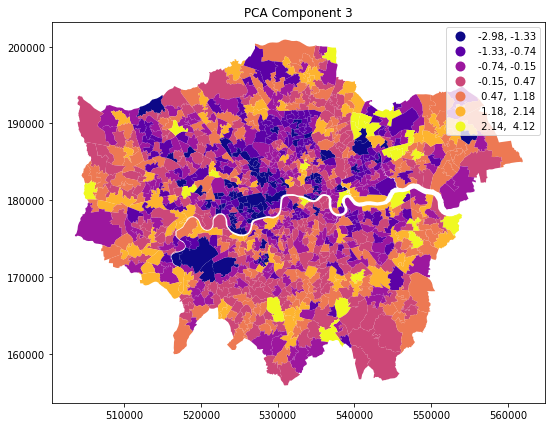

In [75]:
for i in range(1,4):
    ax = pcadf.plot(column=f"Component {i}", cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
    ax.set_title(f'PCA Component {i}')

## 7. t-SNE

#### Task 7.1: t-SNE Using PCA Components

In [76]:
from sklearn.manifold import TSNE

# You might want to experiment with all
# 3 of these values -- it may make sense 
# to package a lot of this up into a function!
keep_dims=2
lrn_rate=150
prp=50

tsnedf = pcadf.loc[:,'Component 1':f"Component {keep_n_components}"].copy()

tsne = TSNE(n_components=keep_dims, perplexity=prp, random_state=42, n_iter=5000, n_jobs=-1)
X_embedded = tsne.fit_transform(tsnedf)
X_embedded.shape

(983, 2)

#### Task 7.2: Copy Dimensions Back to Data Frame

In [77]:
for x in [X_embedded]:
    new_columns = []
    
    for i in range(0,keep_dims):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_dims):
            new_columns[j].append(i[j])

    for i in range(0,keep_dims):
        tsnedf[f"Dimension {i+1}"] = new_columns[i]

#### Task 7.3: Merge and Project

In [78]:
rddf = pd.merge(msoas.set_index('MSOA11CD'), tsnedf, left_index=True, right_index=True, how='inner')
rddf.sample(3)

,OBJECTID,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm,geometry,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Dimension 1,Dimension 2
MSOA11CD,,,,,,,,,,,,,,,,,,,
E02000727,703,Newham 014,541459,184181,Newham,Plashet West,"POLYGON ((541314.161 183814.467, 541267.147 18...",-1.188607,0.821315,-1.110319,1.429973,-2.699273,0.114864,-0.281867,0.582480,0.424347,0.962695,11.758931,-14.692457
E02000519,500,Hillingdon 026,510439,180940,Hillingdon,Hayes Town North,"POLYGON ((511234.039 181739.081, 511316.164 18...",-0.969828,-0.066671,-0.066129,1.178249,-0.140513,-0.037762,0.532827,0.137960,-0.460030,0.675167,7.049036,-9.225121
E02000424,409,Haringey 028,530726,188601,Haringey,Hornsey Vale,"POLYGON ((530807.000 189094.000, 530857.990 18...",0.281107,0.046478,-0.706192,-1.184968,0.029258,-0.691160,-0.117991,0.252887,-0.122250,-0.611268,3.814301,11.551112


#### Task 7.4: Visualise!

In [79]:
rddf['Subregion'] = rddf.Borough.apply(lambda x: mapping[x])

In [80]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")
# Set the *hue order* so that all plots have some colouring by Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

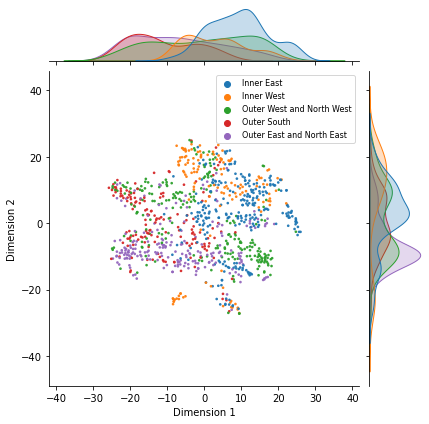

In [81]:
g = sns.jointplot(data=rddf, x='Dimension 1', y='Dimension 2', 
                  hue='Subregion', hue_order=ho, joint_kws=kwds)
g.ax_joint.legend(loc='upper right', prop={'size': 8});

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


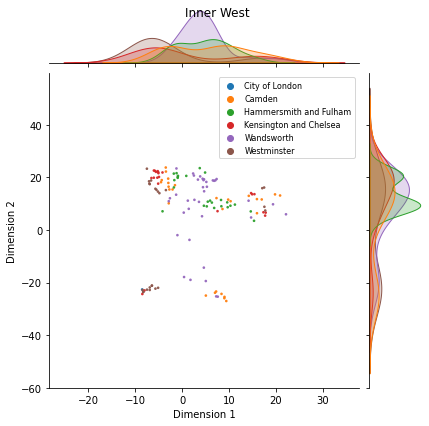

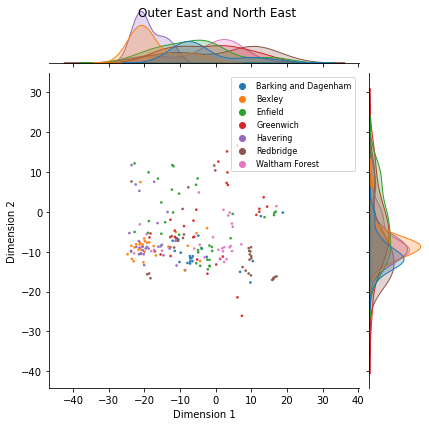

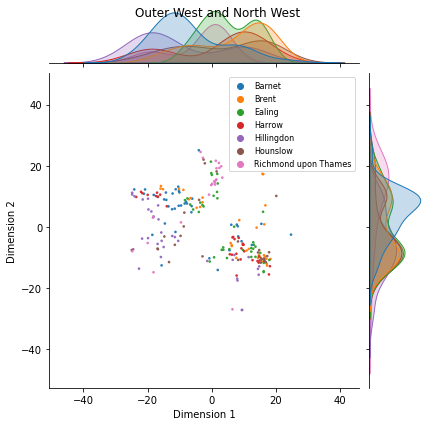

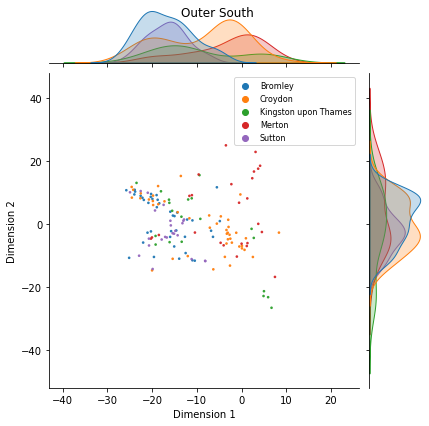

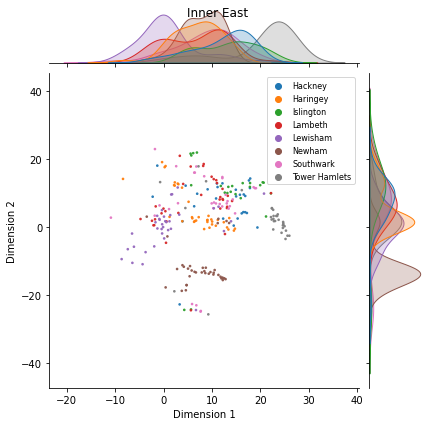

In [82]:
for r in rddf.Subregion.unique():
    g = sns.jointplot(data=rddf[rddf.Subregion==r], x='Dimension 1', y='Dimension 2', 
                  hue='Borough', joint_kws=kwds)
    g.ax_joint.legend(loc='upper right', prop={'size': 8});
    plt.suptitle(r)

We can't unfortunately do any clustering at this point to create groups from the data (that's next week!) so for now note that there are several large-ish groups (in terms of membership) and few small ones picked up by t-SNE. Alos note that there is strong evidence of some incipient structure: Inner East and West largely clump together, while Outher East and Outer South also seem to group together, with Outer West being more distinctive. If you look back at the PCA Components (especially \#1) you might be able to speculate about some reasons for this! Please note: this is _only_ speculation at this time!

Next week we'll also add the listings data back in as part of the picture!

#### And Save

In [83]:
rddf.to_file(os.path.join('data','clean','Reduced_Dimension_Data.gpkg'), driver='GPKG')

## Credits!

#### Contributors:
The following individuals have contributed to these teaching materials: Jon Reades (j.reades@ucl.ac.uk).

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

#### Potential Dependencies:
This notebook may depend on the following libraries: pandas, geopandas, sklearn, matplotlib, seaborn